In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from dataloader import Synthesizer
from regression import DF, IL

In [2]:
%matplotlib inline
np.random.seed(0)

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
n_train = 30
n_test = 200
exp_par, offset = 3, 1
corruption = exp_par, offset
proportion = .7

datagen = Synthesizer('IR-' + str(n_train))
x_train, y_train = datagen.get_trainset()
x_test, y_test = datagen.get_testset(n_test)
S_train = datagen.synthetic_corruption(y_train, corruption, skewed=False)
c_train, r_train = S_train

y_train += 3
c_train += 3
y_test += 3

bad_ind = np.random.rand(n_train) < proportion
S_train = (c_train, r_train, bad_ind)
good_ind = ~bad_ind

In [4]:
def l2_loss(A, B):
    dist = A @ B.T
    dist *= -2
    dist += np.sum(A ** 2, axis=1)[:, np.newaxis]
    dist += np.sum(B ** 2, axis=1)
    return dist


def point_l2_loss(a, b):
    dist = a - b
    dist **= 2
    dist = np.sum(dist, axis=1)
    return dist

In [5]:
def projection_df_pr(ys, Ss):
    cs, rs, bad_ind = Ss
    ind = ys.squeeze() < 0
    ind &= bad_ind
    ys[ind] *= -1
    diff = (ys - cs).squeeze()
    outside = np.abs(diff) > rs
    ys[outside] = cs[outside] + (rs[outside] * np.sign(diff)[outside])[:, np.newaxis]
    ys[ind] *= -1
    return ys

In [6]:
y_grid = np.linspace(-6, 6, num=1000)[:, np.newaxis]
AC_loss = l2_loss(c_train, y_grid)
AC_loss[bad_ind] = np.sum(y_grid ** 2, axis=1)

IL_loss_pos = l2_loss(c_train, y_grid)
IL_loss_pos -= r_train[:, np.newaxis]
IL_loss_neg = l2_loss(-c_train, y_grid)
IL_loss_neg -= r_train[:, np.newaxis]
IL_loss_neg[good_ind] = np.inf
IL_loss = np.stack((IL_loss_pos, IL_loss_neg)).min(axis=0)
IL_loss[IL_loss < 0] = 0
IL_loss **= 2

In [7]:
kernel_type = 'Gaussian'
# kernel_type = 'Laplacian'
# sigmas = [1e0, 5e-1, 1e-1, 5e-2, 1e-2]
sigmas = [1e-1, 5e-2, 1e-2, 5e-3]
lambdas = [1e12, 1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9]

In [8]:
kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train)

best_err_df, best_err_il, best_err_ac = 3 * (np.inf,)

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)
        
        alpha = kernel_reg(x_train)        
        y_dis = DF.disambiguation(alpha, S_train, 10e-6, 10e6, projection_df_pr)
        
        alpha = kernel_reg(x_test)
        alpha /= alpha.sum(axis=1)[:, np.newaxis]

        y_df = alpha @ y_dis
#         y_il = IL.disambiguation(alpha, S_train, 10e-6, 10e3, projection_il_df)
        loss_grid = alpha @ IL_loss
        y_il = y_grid[np.argmin(loss_grid, axis=1)]
        loss_grid = alpha @ AC_loss
        y_ac = y_grid[np.argmin(loss_grid, axis=1)]
        
        err_df = np.diag(l2_loss(y_df, y_test)).mean()
        err_il = np.diag(l2_loss(y_il, y_test)).mean()
        err_ac = np.diag(l2_loss(y_ac, y_test)).mean()
        
        if err_df < best_err_df:
            best_err_df = err_df
            best_y_df = y_df
            best_dis = y_dis
            best_s_df = sigma
            best_l_df = lambd
        if err_il < best_err_il:
            best_err_il = err_il
            best_y_il = y_il
            best_s_il = sigma
            best_l_il = lambd   
        if err_ac < best_err_ac:
            best_err_ac = err_ac
            best_y_ac = y_ac
            best_s_ac = sigma
            best_l_ac = lambd
        print('.', end='')

................................

In [9]:
print(best_err_df, best_err_il, best_err_ac)
print(best_s_df, best_s_il, best_s_ac, best_l_df, best_l_il, best_l_ac)

0.07611916958377354 0.19630352903532686 4.875013843343144
0.1 0.05 0.1 1e-06 1000000000000.0 1.0


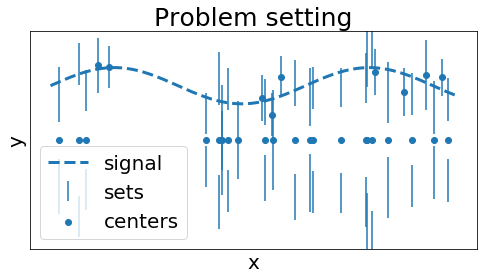

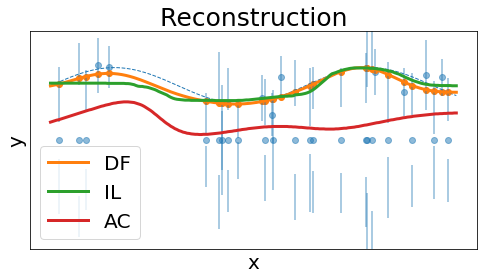

In [10]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
a, = ax1.plot(x_test[:, 0], y_test[:, 0], linestyle="--", linewidth=3, color="C0")
b = ax1.errorbar(x_train[:, 0], c_train[:, 0], yerr=r_train, fmt=' ', color="C0")
ax1.errorbar(x_train[bad_ind, :], -c_train[bad_ind, 0], yerr=r_train[bad_ind], fmt=' ', color="C0")
c = ax1.scatter(x_train[bad_ind, 0], np.zeros(bad_ind.sum()), color="C0")
ax1.scatter(x_train[good_ind, 0], c_train[good_ind, 0], color="C0")
ax1.legend([a, b, c], ["signal", "sets", "centers"], prop={"size": 20})
ax1.set_title("Problem setting", size=25)

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(x_test[:, 0], y_test[:, 0], linestyle="--", linewidth=1, color="C0")
alpha = .5
ax2.errorbar(x_train[:, 0], c_train[:, 0], yerr=r_train, fmt=' ', color="C0", alpha=alpha)
ax2.errorbar(x_train[bad_ind, :], -c_train[bad_ind, 0], yerr=r_train[bad_ind], fmt=' ', color="C0", alpha=alpha)
ax2.scatter(x_train[bad_ind, 0], np.zeros(bad_ind.sum()), color="C0", alpha=alpha)
ax2.scatter(x_train[good_ind, 0], c_train[good_ind, 0], color="C0", alpha=alpha)
a, = ax2.plot(x_test.squeeze(), best_y_df.squeeze(), linestyle="-", linewidth=3, color="C1")
ax2.scatter(x_train.squeeze(), best_dis.squeeze(), color="C1")
b, = ax2.plot(x_test.squeeze(), best_y_il.squeeze(), linestyle="-", linewidth=3, color="C2")
c, = ax2.plot(x_test.squeeze(), best_y_ac.squeeze(), linestyle="-", linewidth=3, color="C3")
# ax2.legend([a, b], ['DF', 'IL'], prop={'size':20})
ax2.legend([a, b, c], ['DF', 'IL', 'AC'], prop={'size':20})
ax2.set_title("Reconstruction", size=25)

for ax in [ax1, ax2]:
    ax.set_xlabel("x", size=20)
    ax.set_ylabel("y", size=20)
    ax.set_ylim(-6, 6)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

# fig1.savefig('savings/ir_setting.pdf')
# fig2.savefig('savings/ir_reconstruction.pdf')